In [2]:
# %load csvpolygons_creator.py
import pandas as pd
import argparse
import logging
import json
import os
import pathlib
import fiona
import numpy as np
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from geopandas.tools import geocode
from shapely.geometry import Point
import requests
#import geojson

### Instructions on getting Data from geo.admin.ch API: ### https://api.geo.admin.ch/services/sdiservices.html#rest-services

### Downloaded shapefiles from swissBOUNDARIES3D (https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html)

disponible dans les formats de données suivant :
- ESRI File Geodatabase
- ESRI Shapefile
- DXF (prière d’adresser vos commandes à geodata@swisstopo.ch)
- Interlis 2

Systèmes de coordonnées: MN95 NF02

## Load district boundaries

In [3]:
pathlib.Path()
NOTEBOOK_PATH = pathlib.Path().resolve()
p = NOTEBOOK_PATH.parent
DATA_DIRECTORY = p / "data"
MAP_DIRECTORY = DATA_DIRECTORY /'maps'

#DISTRICTS
D_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_BEZIRKSGEBIET.shp"
D_AMB = "Bellinzona"

#MUNICIPALITIES
MUN_AMB = ["Arbedo-Castione", "Bellinzona", "Cadenazzo", "Isone", "Lumino","Sant'Antonino"]

FILE_PATH = MAP_DIRECTORY / D_FILE

In [4]:
# Read the shp file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
raw_limes = gpd.read_file(FILE_PATH)
limes = raw_limes.to_crs(epsg=2056)
limes.head()

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,...,BEZIRKSNUM,SEE_FLAECH,REVISION_Q,BEZIRKSFLA,BEZIRK_TEI,NAME,KANTONSNUM,ICC,EINWOHNERZ,geometry
0,{9D91928E-115F-43DA-AF90-10625E58B7F9},2020-11-19,2012-10-26,2012,10,2023,1,Verbessert,AV,2020,...,1850,NaN,sb_2022_3D,137355.0,0,Surselva,18,CH,21438.0,"POLYGON ((2700578.046 1159167.279, 2700566.494..."
1,{18B8E2A0-F043-4198-87FC-119BA9F5E762},2022-10-24,2012-10-26,2012,10,2023,1,Verbessert,AV,2023,...,250,0.0,sb_2022_3D,122931.0,1,Interlaken-Oberhasli,2,CH,47811.0,"POLYGON ((2629760.290 1168259.810, 2629760.150..."
2,{1C504398-486E-49F8-A024-B59233F9DE89},2018-11-22,2012-10-26,2012,10,2023,1,Verbessert,AV,2019,...,1843,NaN,sb_2022_3D,119653.0,0,Engiadina Bassa/Val Müstair,18,CH,9189.0,"POLYGON ((2803369.136 1191207.211, 2803391.348..."
3,{FDA49AE0-D4C8-43EF-9275-0624413C5949},2020-11-19,2012-10-26,2012,10,2023,1,Verbessert,AV,2020,...,1846,NaN,sb_2022_3D,97358.0,0,Maloja,18,CH,18236.0,"POLYGON ((2800111.240 1150594.671, 2800165.234..."
4,{25673BF2-FF32-48E3-AA80-880EA3D4B856},2022-11-14,2012-10-26,2012,10,2023,1,Verbessert,AV,2023,...,246,NaN,sb_2022_3D,94245.0,1,Bern-Mittelland,2,CH,418807.0,"POLYGON ((2604676.804 1183530.496, 2604585.356..."


## filter for Bellinzona

In [5]:
AMB_district = limes[limes.NAME == "Bellinzona"]
AMB_district_2 = AMB_district[["NAME", "geometry"]]
AMB_district_2

,NAME,geometry
54,Bellinzona,"POLYGON ((2727358.511 1119219.094, 2727430.611..."


# 2. Generation Plants data

In [6]:
PLANT_DIRECTORY = DATA_DIRECTORY /'ElectricityProduction_EPSG2056'
plants =  gpd.read_file(PLANT_DIRECTORY / "ElectricityProductionPlants.gpkg")
plants

,xtf_id,Address,PostCode,Municipality,Canton,BeginningOfOperation,InitialPower,TotalPower,MainCategory,SubCategory,PlantCategory,geometry
0,14727,Schlossstrasse 15,4147,Aesch BL,BL,2009-05-05,14.65,18.81,maincat_2,subcat_2,plantcat_9,None
1,14728,Ob der Steig 1,5082,Kaisten,AG,2011-10-28,5.80,5.80,maincat_2,subcat_2,plantcat_8,POINT (2645765.000 1265097.000)
2,10164,Gässli 4,3114,Wichtrach,BE,2008-10-07,3.00,3.00,maincat_2,subcat_2,plantcat_8,POINT (2610547.000 1188978.000)
3,10794,Diemtigtalstrasse 46,3753,Oey,BE,2008-06-27,8.40,8.40,maincat_2,subcat_2,plantcat_8,POINT (2610530.000 1167346.000)
4,9476,Holzweidstrasse 8,8340,Hinwil,ZH,2006-04-21,4.80,4.80,maincat_2,subcat_2,plantcat_8,POINT (2705859.000 1240558.000)
...,...,...,...,...,...,...,...,...,...,...,...,...
141183,50526,Kalchrainstrasse 12,6315,Oberägeri,ZG,1996-04-04,3.00,3.00,maincat_2,subcat_2,,POINT (2689645.000 1221007.000)
141184,50527,Bahnhofstrasse 18,6300,Zug,ZG,2001-07-04,3.00,3.00,maincat_2,subcat_2,,POINT (2681678.000 1224818.000)
141185,51006,Zugimattstrasse 7,3638,Blumenstein,BE,2004-07-21,1.00,1.00,maincat_2,subcat_2,,POINT (2606413.000 1176995.000)
141186,15984,Hirzenstrasse 14,4125,Riehen,BS,2005-07-08,4.90,4.90,maincat_2,subcat_2,,POINT (2616010.000 1269781.000)


In [7]:
CH_districts = limes[["NAME", "geometry"]]
Within_AMB = plants.within(AMB_district_2.at[54,"geometry"])
Within_AMB.value_counts()

False    140286
True        902
dtype: int64

In [8]:
plants_in_AMB_district = plants[plants.within(AMB_district_2.at[54,"geometry"])]
PV_plants_AMB = plants_in_AMB_district.loc[plants_in_AMB_district["SubCategory"]== "subcat_2"]
PV_plants_AMB

,xtf_id,Address,PostCode,Municipality,Canton,BeginningOfOperation,InitialPower,TotalPower,MainCategory,SubCategory,PlantCategory,geometry
644,10883,Via al Vallone 11d,6514,Sementina,TI,2007-12-17,5.00,5.00,maincat_2,subcat_2,plantcat_8,POINT (2720281.000 1115887.000)
888,11141,Ai Basciòcch 18,6528,Camorino,TI,2009-02-11,4.40,4.40,maincat_2,subcat_2,plantcat_9,POINT (2720764.000 1113473.000)
967,18723,Via Cornigo 4b,6503,Bellinzona,TI,2008-11-12,3.46,9.72,maincat_2,subcat_2,plantcat_8,POINT (2721435.000 1118140.000)
1145,10207,Via Pro Grand 5,6514,Sementina,TI,2008-04-22,3.30,3.30,maincat_2,subcat_2,plantcat_8,POINT (2719841.000 1115723.000)
1561,9727,Vicolo Sottocorte,6500,Bellinzona,TI,2008-05-15,1.00,1.00,maincat_2,subcat_2,plantcat_9,POINT (2721946.000 1116760.000)
...,...,...,...,...,...,...,...,...,...,...,...,...
138092,113116,Via San Giobbe (Mappale 454),6512,Giubiasco,TI,2014-08-19,43.46,43.46,maincat_2,subcat_2,,POINT (2721170.000 1114628.000)
138109,113908,Via Campagna 10,6512,Giubiasco,TI,2014-04-04,32.76,32.76,maincat_2,subcat_2,,POINT (2720414.000 1114302.000)
139082,133021,Via Serrai 3,6592,S. Antonino,TI,2012-06-14,379.20,379.20,maincat_2,subcat_2,,POINT (2717566.000 1112611.000)
140272,8371,Via ai Ronchi 23,6500,Bellinzona,TI,2004-03-25,5.00,5.00,maincat_2,subcat_2,,POINT (2723224.000 1117284.000)


## save PV plants in csv file

In [9]:
PV_plants_AMB_file = "PV_plants_AMB.csv"
PV_plants_AMB.to_csv(PV_plants_AMB_file, sep=",")

# 4. Buildings data

## Clasification and calculation of SH and DHW

In [14]:
#specific space heating demand of residential buildings
HIGH = 15 # [kwh/m2y]
MOD = 70 # [kwh/m2y]
LOW = 115 # [kwh/m2y]
VLOW = 145 # [kwh/m2y]

In [15]:
BLG_DIRECTORY = DATA_DIRECTORY /'Buildings_rea'
bldgs_raw =  pd.read_csv(BLG_DIRECTORY / "GWR_MADD_GEB-05_Data_MADD-20211026-A4_20211029.csv")
bldgs = bldgs_raw[['EGID', 'GKODE', 'GKODN',
                           'GSTAT', 'GKAT', 'GKLAS', 'GBAUJ', 'GBAUP', 'GRENJ', 'GABBJ', 'GAREA','GASTW', 
                           'GWAERZH1', 'GENH1', 'GWAERDATH1', 'GWAERZH2', 'GENH2', 'GWAERDATH2', 
                           'GWAERZW1', 'GENW1', 'GWAERDATW1','GWAERZW2', 'GENW2', 'GWAERDATW2', 
                           'Create_Date','Update_Date', 'GGDENR', 'GDENAME', 'GDEKT']]

In [16]:
bldg_SFH_pd = bldgs.loc[(bldgs["GKLAS"]== 1110) & (bldgs["GSTAT"]== 1004)]
bldg_DFH_pd = bldgs.loc[(bldgs["GKLAS"]== 1121) & (bldgs["GSTAT"]== 1004)]
bldg_MFH_pd = bldgs.loc[(bldgs["GKLAS"]== 1122) & (bldgs["GSTAT"]== 1004)]

bldg_SFH_pd.tail()

,EGID,GKODE,GKODN,GSTAT,GKAT,GKLAS,GBAUJ,GBAUP,GRENJ,GABBJ,...,GENW1,GWAERDATW1,GWAERZW2,GENW2,GWAERDATW2,Create_Date,Update_Date,GGDENR,GDENAME,GDEKT
178102,400087798,2708474.240,1121453.165,1004,1020.0,1110.0,NaN,8011.0,NaN,NaN,...,NaN,02/03/2017,NaN,NaN,NaN,02/03/2017,28/10/2020,5399,Verzasca,TI
178103,400087799,2708476.737,1121449.615,1004,1020.0,1110.0,NaN,8011.0,NaN,NaN,...,NaN,02/03/2017,NaN,NaN,NaN,02/03/2017,28/10/2020,5399,Verzasca,TI
178104,400088216,2704495.250,1133048.334,1004,1020.0,1110.0,NaN,8012.0,2001.0,NaN,...,NaN,14/12/2017,NaN,NaN,NaN,14/12/2017,28/10/2020,5399,Verzasca,TI
178105,400088272,2704934.250,1131881.300,1004,1020.0,1110.0,NaN,8012.0,1970.0,NaN,...,NaN,14/12/2017,NaN,NaN,NaN,14/12/2017,04/10/2021,5399,Verzasca,TI
178106,400088273,2704243.219,1131704.303,1004,1020.0,1110.0,NaN,8012.0,1990.0,NaN,...,NaN,14/12/2017,NaN,NaN,NaN,14/12/2017,27/01/2020,5399,Verzasca,TI


In [17]:
bldg_SFH_pd_AMB = bldg_SFH_pd.loc[bldg_SFH_pd["GDENAME"].isin(MUN_AMB)]
bldg_DFH_pd_AMB = bldg_DFH_pd.loc[bldg_DFH_pd["GDENAME"].isin(MUN_AMB)]
bldg_MFH_pd_AMB = bldg_MFH_pd.loc[bldg_MFH_pd["GDENAME"].isin(MUN_AMB)]  

bldg_SFH_pd_AMB.tail()

,EGID,GKODE,GKODN,GSTAT,GKAT,GKLAS,GBAUJ,GBAUP,GRENJ,GABBJ,...,GENW1,GWAERDATW1,GWAERZW2,GENW2,GWAERDATW2,Create_Date,Update_Date,GGDENR,GDENAME,GDEKT
24158,400087736,2720024.392,1112191.082,1004,1020.0,1110.0,NaN,8013.0,1987.0,NaN,...,NaN,02/03/2017,NaN,NaN,NaN,02/03/2017,27/01/2020,5017,Sant'Antonino,TI
24159,400087737,2718300.368,1112027.076,1004,1020.0,1110.0,1973.0,8015.0,1990.0,NaN,...,NaN,02/03/2017,NaN,NaN,NaN,02/03/2017,27/01/2020,5017,Sant'Antonino,TI
24160,400087738,2717874.361,1112214.077,1004,1020.0,1110.0,NaN,8012.0,1993.0,NaN,...,NaN,02/03/2017,NaN,NaN,NaN,02/03/2017,27/01/2020,5017,Sant'Antonino,TI
24161,400087739,2717892.361,1112215.077,1004,1020.0,1110.0,NaN,8011.0,NaN,NaN,...,NaN,02/03/2017,NaN,NaN,NaN,02/03/2017,27/01/2020,5017,Sant'Antonino,TI
24162,400087740,2718953.570,1112462.440,1004,1020.0,1110.0,NaN,8012.0,NaN,NaN,...,NaN,02/03/2017,NaN,NaN,NaN,02/03/2017,27/01/2020,5017,Sant'Antonino,TI


In [18]:
#USTAT 2019
# Arbedo-Castione = 1091 edifici esclusivamente abitativi https://www3.ti.ch/DFE/DR/USTAT/allegati/comune/101arbedo-castione.pdf
# Bellinzona = 10641 edifici esclusivamente abitativi  https://www3.ti.ch/DFE/DR/USTAT/allegati/comune/669bellinzona.pdf
# Cadenazzo = 653 https://www3.ti.ch/DFE/DR/USTAT/allegati/comune/111cadenazzo.pdf
# Isone = 239 https://www3.ti.ch/DFE/DR/USTAT/allegati/comune/168isone.pdf
# Lumino = 481 https://www3.ti.ch/DFE/DR/USTAT/allegati/comune/106lumino.pdf
# SantAntonino = 667 https://www3.ti.ch/DFE/DR/USTAT/allegati/comune/139santantonino.pdf
## TOTAL = 13772 edifici esclusivamente abitativi (5% less than bldg_res_AMB) 

GKLAS_SFH = 1110
GKLAS_DFH = 1121
GKLAS_MFH = 1122
GKLAS_RES = [GKLAS_SFH, GKLAS_DFH, GKLAS_MFH]
bldg_res_AMB = bldgs.loc[(bldgs["GKLAS"].isin(GKLAS_RES) & (bldgs["GSTAT"]== 1004) & bldgs["GDENAME"].isin(MUN_AMB))]

bldg_res_SFH_AMB = bldgs.loc[((bldgs["GKLAS"]== GKLAS_SFH) & (bldgs["GSTAT"]== 1004) & bldgs["GDENAME"].isin(MUN_AMB))]

print("bldgs_res_AMB = ",len(bldg_res_AMB), "SFH = ", len(bldg_SFH_pd_AMB), "DFH = ", len(bldg_DFH_pd_AMB),"MFH = ", len(bldg_MFH_pd_AMB),"bldg_res_SFH_AMB= ", len(bldg_res_SFH_AMB) ) 

bldgs_res_AMB =  14517 SFH =  9881 DFH =  2330 MFH =  2306 bldg_res_SFH_AMB=  9881


## Arbedo-Castione

In [37]:
bldg_res_AC = bldg_res_AMB.loc[(bldgs["GDENAME"]=="Arbedo-Castione")]
bldg_res_AC_MFH = bldg_res_AC.loc[(bldgs["GKLAS"]== GKLAS_MFH)] 
print("Arbedo-Castione tot = ",len(bldg_res_AC), "Arbedo-Castione MFH = ",len(bldg_res_AC_MFH), "percent MFH = ", round((len(bldg_res_AC_MFH)/len(bldg_res_AC)),2)*100)

Arbedo-Castione tot =  1123 Arbedo-Castione MFH =  195 percent MFH =  17.0


## Bellinzona

In [38]:
bldg_res_B = bldg_res_AMB.loc[(bldgs["GDENAME"]=="Bellinzona")]
bldg_res_B_MFH = bldg_res_B.loc[(bldgs["GKLAS"]== GKLAS_MFH)] 
print("Bellinzona tot = ",len(bldg_res_B), "Bellinzona MFH = ",len(bldg_res_B_MFH), "percent MFH = ", round((len(bldg_res_B_MFH)/len(bldg_res_B)),2)*100)

Bellinzona tot =  11280 Bellinzona MFH =  1874 percent MFH =  17.0


## Cadenazzo

In [39]:
bldg_res_C = bldg_res_AMB.loc[(bldgs["GDENAME"]=="Cadenazzo")]
bldg_res_C_MFH = bldg_res_C.loc[(bldgs["GKLAS"]== GKLAS_MFH)] 
print("Cadenazzo tot = ",len(bldg_res_C), "Cadenazzo MFH = ",len(bldg_res_C_MFH), "percent MFH = ", round((len(bldg_res_C_MFH)/len(bldg_res_C)),2)*100)

Cadenazzo tot =  695 Cadenazzo MFH =  92 percent MFH =  13.0


## Lumino

In [40]:
bldg_res_L = bldg_res_AMB.loc[(bldgs["GDENAME"]=="Lumino")]
bldg_res_L_MFH = bldg_res_L.loc[(bldgs["GKLAS"]== GKLAS_MFH)] 
print("Lumino tot = ",len(bldg_res_L), "Lumino MFH = ",len(bldg_res_L_MFH), "percent MFH = ", round((len(bldg_res_L_MFH)/len(bldg_res_L)),2)*100)

Lumino tot =  498 Lumino MFH =  64 percent MFH =  13.0


## SantAntonino

In [41]:
bldg_res_SA = bldg_res_AMB.loc[(bldgs["GDENAME"]=="Sant'Antonino")]
bldg_res_SA_MFH = bldg_res_SA.loc[(bldgs["GKLAS"]== GKLAS_MFH)] 
print("Sant'Antonino tot = ",len(bldg_res_SA), "Sant'Antonino MFH = ",len(bldg_res_SA_MFH), "percent MFH = ", round((len(bldg_res_SA_MFH)/len(bldg_res_SA)),2)*100)

Sant'Antonino tot =  677 Sant'Antonino MFH =  75 percent MFH =  11.0


# Filter for heating tech

In [20]:
bldg_SFH_AMB_HTG = bldg_SFH_pd_AMB[['GBAUP', 'GAREA','GWAERZH1','GWAERZH2','GWAERZW1','GWAERZW2']]
bldg_SFH_AMB_HTG = bldg_SFH_AMB_HTG.reset_index(drop = True)

In [21]:
bldg_SFH_AMB_HTG_csv = "bldg_SFH_AMB_HTG.csv"
bldg_SFH_AMB_HTG.to_csv(bldg_SFH_AMB_HTG_csv, sep=",")

In [25]:
GBAUP = [8011,8012,8013,8014,8015,8016,8017,8018,8019,8020,8021,8022,8023]

bldg_SFH_AMB_HTG_AGE = bldg_SFH_AMB_HTG.groupby(['GBAUP']).mean()
bldg_SFH_AMB_HTG_AGE

,GAREA,GWAERZH1,GWAERZH2,GWAERZW1,GWAERZW2
GBAUP,,,,,
8011.0,79.719118,7430.365706,7400.0,7631.300347,7600.0
8012.0,64.898531,7434.883156,7400.0,7631.915306,7600.0
8013.0,85.849457,7434.612222,7400.0,7635.974459,7600.0
8014.0,113.750294,7431.988024,7400.0,7631.987952,7600.0
8015.0,120.002857,7432.345029,7400.0,7632.047965,7600.0
8016.0,101.748201,7437.120393,7400.0,7638.124088,7600.0
8017.0,95.808511,7434.641288,7400.0,7636.772263,7600.0
8018.0,99.470000,7432.177215,7400.0,7633.629442,7600.0
8019.0,117.659472,7430.153477,7400.0,7630.455635,7600.0


In [23]:
GAREA_Med_by_GBAUP= bldg_SFH_AMB_HTG_AGE["GAREA"]
type(GAREA_Med_by_GBAUP)

pandas.core.series.Series

# GEOPANDA - create points from GKODE and GKODN

In [26]:
bldg_geo = gpd.GeoDataFrame(bldgs, geometry=gpd.points_from_xy(bldgs.GKODE, bldgs.GKODN))
bldg_geo.columns

Index(['EGID', 'GKODE', 'GKODN', 'GSTAT', 'GKAT', 'GKLAS', 'GBAUJ', 'GBAUP',
       'GRENJ', 'GABBJ', 'GAREA', 'GASTW', 'GWAERZH1', 'GENH1', 'GWAERDATH1',
       'GWAERZH2', 'GENH2', 'GWAERDATH2', 'GWAERZW1', 'GENW1', 'GWAERDATW1',
       'GWAERZW2', 'GENW2', 'GWAERDATW2', 'Create_Date', 'Update_Date',
       'GGDENR', 'GDENAME', 'GDEKT', 'geometry'],
      dtype='object')

In [27]:
bldg_geo.head()

,EGID,GKODE,GKODN,GSTAT,GKAT,GKLAS,GBAUJ,GBAUP,GRENJ,GABBJ,...,GWAERDATW1,GWAERZW2,GENW2,GWAERDATW2,Create_Date,Update_Date,GGDENR,GDENAME,GDEKT,geometry
0,1624264,2723529.469,1118996.124,1004,1040.0,NaN,NaN,8011.0,2014.0,NaN,...,11/06/2004,NaN,NaN,NaN,11/06/2004,27/01/2020,5001,Arbedo-Castione,TI,POINT (2723529.469 1118996.124)
1,1624402,2723875.830,1119249.610,1004,1060.0,1274.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11/06/2004,27/01/2020,5001,Arbedo-Castione,TI,POINT (2723875.830 1119249.610)
2,1624478,2723642.471,1119515.128,1004,1040.0,1211.0,NaN,8014.0,1980.0,NaN,...,11/06/2004,NaN,NaN,NaN,11/06/2004,27/01/2020,5001,Arbedo-Castione,TI,POINT (2723642.471 1119515.128)
3,1624840,2724507.980,1120381.330,1004,1060.0,NaN,NaN,8014.0,NaN,NaN,...,NaN,NaN,NaN,NaN,11/06/2004,27/01/2020,5001,Arbedo-Castione,TI,POINT (2724507.980 1120381.330)
4,1625008,2723858.590,1120352.820,1004,1020.0,1110.0,NaN,8014.0,NaN,NaN,...,11/06/2004,NaN,NaN,NaN,11/06/2004,27/01/2020,5001,Arbedo-Castione,TI,POINT (2723858.590 1120352.820)


## filter for AMB

<AxesSubplot: >

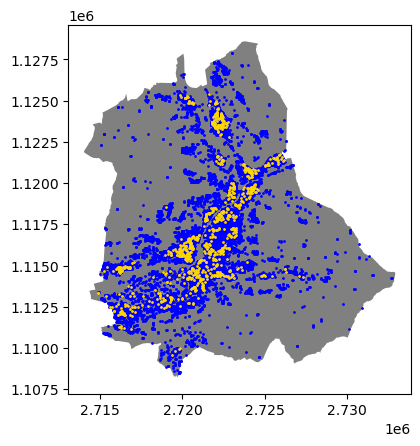

In [28]:
bldgs_in_AMB_district = bldg_geo[bldg_geo.within(AMB_district_2.at[54,"geometry"])]
axes = AMB_district_2.plot(facecolor="grey")
bldgs_in_AMB_district.plot(ax=axes, color="blue",markersize=1)
PV_plants_AMB.plot(ax=axes, color="gold",markersize=1)

In [ ]:
# filter for exisitng residenital buildings
bldg_TI = bldg_geo[['EGID', 'GKODE', 'GKODN',
                           'GSTAT', 'GKAT', 'GKLAS', 'GBAUJ', 'GBAUP', 'GRENJ','GAREA','GASTW', 
                           'GWAERZH1', 'GENH1', 'GWAERDATH1', 'GWAERZH2', 'GENH2', 'GWAERDATH2', 
                           'GWAERZW1', 'GENW1', 'GWAERDATW1','GWAERZW2', 'GENW2', 'GWAERDATW2', 
                           'Create_Date','Update_Date', 'GGDENR', 'GDENAME', 'GDEKT', 'geometry']]
bldg_EXIST = bldg_TI.loc[bldg_TI["GSTAT"]== 1004]
print(len(bldg_EXIST), bldg_EXIST.count())

In [ ]:
bldg_SFH = bldg_EXIST.loc[bldg_EXIST["GKLAS"]== 1110]
bldg_DFH = bldg_EXIST.loc[bldg_EXIST["GKLAS"]== 1121] 
bldg_MFH = bldg_EXIST.loc[bldg_EXIST["GKLAS"]== 1122] 

In [ ]:
bldg_SFH_AMB = bldg_SFH.loc[bldg_SFH["GDENAME"].isin(MUN_AMB)]
bldg_DFH_AMB = bldg_DFH.loc[bldg_DFH["GDENAME"].isin(MUN_AMB)]
bldg_MFH_AMB = bldg_MFH.loc[bldg_MFH["GDENAME"].isin(MUN_AMB)] 

axes = AMB_district_2.plot(facecolor="grey")
bldg_SFH_AMB.plot(ax=axes, color="red",markersize=1)
bldg_DFH_AMB.plot(ax=axes, color="white",markersize=1)
bldg_MFH_AMB.plot(ax=axes, color="blue",markersize=1)

In [ ]:
print("bldg_SFH_AMB: ",len(bldg_SFH_AMB),"bldg_DFH_AMB: ",len(bldg_DFH_AMB),"bldg_MFH_AMB: ",len(bldg_MFH_AMB))

### htg technology groups AMB

# 3. PV max potentials from geo.admin.ch

### create function that gets PV potential based on coordinates and building_id- works!

In [ ]:
def get_PV_pot_bldgid(building_id):
    TOT_DATA = pd.DataFrame()
    url = 'https://api3.geo.admin.ch//rest/services/api/MapServer/find?'
    params = dict(
        layer='ch.bfe.solarenergie-eignung-daecher',
        searchField='building_id',
        searchText= building_id,
        contains='false'
    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    temp = json.loads(res.text)
    temp_3 = pd.DataFrame.from_dict(temp, orient="index")
    for i in range(len(temp_3.T)):
        POT_bldg_PV_data =  pd.DataFrame.from_dict(temp_3.iat[0,i],orient="index")
        POT_attributes = POT_bldg_PV_data.loc["attributes"].to_dict()
        POT_attr = pd.DataFrame.from_dict(POT_attributes).T
        
        POT_attr = POT_attr[['building_id', 'bedarf_heizung', 'bedarf_warmwasser', 'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag','klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']]
        
        POT_attr = POT_attr.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand',
                                             'flaeche_kollektoren':'area_collectors', 'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                                             'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        
        POT_attr = POT_attr.set_index('label')
        TOT_DATA = pd.concat([TOT_DATA, POT_attr])
    
    return TOT_DATA


def get_PV_pot_coords(coords):
    url = 'https://api3.geo.admin.ch/rest/services/api/MapServer/identify?'
    params = dict(
        lang= "en",
        sr='2056',
        geometryType='esriGeometryPoint',
        geometry=coords,
        imageDisplay='0,0,0',
        mapExtent='0,0,0,0',
        tolerance='0',
        limit=10,
        returnGeometry ="false",
        layers='all:ch.bfe.solarenergie-eignung-daecher'

    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    temp = json.loads(res.text)
    temp_2 = pd.DataFrame.from_dict(temp, orient="columns")
    temp_2.reset_index()
    bldg_PV_data =  pd.DataFrame.from_dict(temp_2.iat[0,0],orient="index")
    bldg_PV_data = bldg_PV_data.rename(columns = {0:"results"})
    #print(bldg_PV_data)
    
    if bldg_PV_data.loc["featureId","results"] == -99:
        #print("no feature at this coordinate")  
        data_fill = [-99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99,  -99, -99, -99]
        PV_POT_attr_filter = pd.DataFrame(data_fill).T
        PV_POT_attr_filter.columns = ['building_id', 'bedarf_heizung', 'bedarf_warmwasser',  'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag', 
                                         'klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']

        PV_POT_attr_filter = PV_POT_attr_filter.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand', 'flaeche_kollektoren':'area_collectors', 
                     'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                     'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        
        PV_POT_attr_filter =  PV_POT_attr_filter.set_index('label')
    else:
        attributes = bldg_PV_data.loc["attributes"].to_dict()
        PV_POT_attr = pd.DataFrame.from_dict(attributes).T

        PV_POT_attr_filter = PV_POT_attr[['building_id', 'bedarf_heizung', 'bedarf_warmwasser',  'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag', 
                                         'klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']]

        PV_POT_attr_filter = PV_POT_attr_filter.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand', 'flaeche_kollektoren':'area_collectors', 
                     'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                     'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        PV_POT_attr_filter = PV_POT_attr_filter.set_index("label")
        #PV_POT_attr_filter = PV_POT_attr_filter.drop(["index"])
        
    #print(PV_POT_attr_filter) 
    return PV_POT_attr_filter

### V1 - REA+PV POTENTIAL - loop through REA buildings to get the PV potenital from each buildings - works!

### V2 PV_Plants-REA- PV potential - loop through REA buildings and get out only bldg with a the PV potenital from each buildings - works!

In [ ]:
csv_names = ["bldg_SFH_AMB_PV.csv", "bldg_DFH_AMB_PV.csv", "bldg_MFH_AMB_PV.csv"]
n=0
TOT = pd.DataFrame()
PV_plants_AMB_test= PV_plants_AMB.copy()
PV_plants_AMB_test['geometry'] = PV_plants_AMB_test['geometry'].buffer(5)
    
for res_type in (bldg_SFH_AMB, bldg_DFH_AMB, bldg_MFH_AMB):
    csv_name = csv_names[n]

    bldg_AMB = res_type.copy()
    bldg_AMB = bldg_AMB.set_crs("EPSG:2056")
    res_type = gpd.sjoin(bldg_AMB, PV_plants_AMB_test)
    
    geo = res_type.reset_index()
    
    for i in range(len(geo)): ##switch to len(geo) after adding skip condition if not attributes found
        
        assert type(geo.loc[i, 'geometry']) == Point, "Your geometry is not of Point type. It is" % type(geo['geometry'])
        coords = str(geo.loc[i, 'geometry'].x) + "," + str(geo.loc[i, 'geometry'].y)
        coords_PV_pot = get_PV_pot_coords(coords)

        if coords_PV_pot.iat[0,0]==-99:
            bldg_PV_pot = coords_PV_pot.reset_index()
            #bldg_PV_pot =  coords_PV_pot
            
        else:
            building_id = str(coords_PV_pot.iat[0,0])
            bldg_PV_pot = get_PV_pot_bldgid(building_id)
            bldg_PV_pot = bldg_PV_pot.reset_index()
        
        #print( "bldg_PV_pot", bldg_PV_pot)
        #print("geo.loc[[i]]", geo.loc[[i]])
        geo_i = geo.loc[[i]]
        geo_i = geo_i.reset_index()
        #print("geo_i", geo_i)
        joint_df = bldg_PV_pot.join(geo_i)
        joint_df["str_geometry"] = joint_df['geometry'].astype(str)
        joint_df = joint_df.drop(["index","GBAUJ","GRENJ", "GWAERZH2","GENH2", "GWAERDATH2","GWAERZW2","GENW2","GWAERDATW2","geometry"], axis=1) 
        joint_df = joint_df.ffill(axis="index").bfill(axis="index")
        #print(joint_df)
        
        TOT = pd.concat([TOT,joint_df], ignore_index=True)
    TOT.to_csv(csv_name)
    print("done with: ", csv_name )
    n=n+1
    TOT = TOT[0:0]

## V3 - PV plants-REA-PV potentials - Merge to keep EGIDS without a PV plant - Works!

In [ ]:
from shapely import wkt

csv_names = ["bldg_SFH_AMB_PV_EGID.csv", "bldg_DFH_AMB_PV_EGID.csv", "bldg_MFH_AMB_PV_EGID.csv"]
n=0
TOT = pd.DataFrame()
PV_plants_AMB_test= PV_plants_AMB.copy()
PV_plants_AMB_test['geometry'] = PV_plants_AMB_test['geometry'].buffer(5)
    
for res_type in (bldg_SFH_AMB, bldg_DFH_AMB, bldg_MFH_AMB):
    csv_name = csv_names[n]

    bldg_AMB_PP = res_type.copy()
    bldg_AMB_PP = bldg_AMB_PP[["EGID","geometry"]]
    bldg_AMB_PP = bldg_AMB_PP.set_crs("EPSG:2056")
    bldg_AMB_PP = gpd.sjoin(bldg_AMB_PP, PV_plants_AMB_test)
    
    geo = res_type.reset_index()
    
    for i in range(len(geo)): ##switch to len(geo) after adding skip condition if not attributes found
        
        assert type(geo.loc[i, 'geometry']) == Point, "Your geometry is not of Point type. It is" % type(geo['geometry'])
        coords = str(geo.loc[i, 'geometry'].x) + "," + str(geo.loc[i, 'geometry'].y)
        coords_PV_pot = get_PV_pot_coords(coords)

        if coords_PV_pot.iat[0,0]==-99:
            bldg_PV_pot = coords_PV_pot.reset_index()
            #bldg_PV_pot =  coords_PV_pot
            
        else:
            building_id = str(coords_PV_pot.iat[0,0])
            bldg_PV_pot = get_PV_pot_bldgid(building_id)
            bldg_PV_pot = bldg_PV_pot.reset_index()
        
        #print( "bldg_PV_pot", bldg_PV_pot)
        #print("geo.loc[[i]]", geo.loc[[i]])
        geo_i = geo.loc[[i]]
        geo_i = geo_i.reset_index()
        #print("geo_i", geo_i)
        joint_df = bldg_PV_pot.join(geo_i)
        joint_df["str_geometry"] = joint_df['geometry'].astype(str)
        joint_df_geo = joint_df['geometry']
        joint_df = joint_df.drop(["index","GBAUJ","GRENJ", "GWAERZH2","GENH2", "GWAERDATH2","GWAERZW2","GENW2","GWAERDATW2","geometry"], axis=1) 
        joint_df = joint_df.ffill(axis="index").bfill(axis="index")
        TOT = pd.concat([TOT,joint_df], ignore_index=True)
        
    TOT = TOT.join(bldg_AMB_PP.set_index('EGID'), on='EGID', validate='m:m')
    TOT.to_csv(csv_name)
    print("done with: ", csv_name )
    n=n+1
    TOT = TOT.drop(['geometry',"index_right","xtf_id","Address","PostCode","Municipality","Canton","BeginningOfOperation","InitialPower","TotalPower","MainCategory","SubCategory","PlantCategory"], axis=1)
    TOT = TOT[0:0]
    

# TESTING CODE

### TEST - get electric plants from Geo.admin.ch - NOT FINISHED YET

In [ ]:
def get_elec_plant_coords(coords_AMB):
    url = 'https://api3.geo.admin.ch/rest/services/api/MapServer/identify?'
    params = dict(
        lang= "en",
        sr='2056',
        geometryType='esriGeometryPoint',
        geometry=coords_AMB,
        imageDisplay='0,0,0',
        mapExtent='0,0,0,0',
        tolerance='0',
        limit=10,
        returnGeometry ="false",
        layers='all:ch.bfe.elektrizitaetsproduktionsanlagen'

    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    temp = json.loads(res.text)
    print(temp)
    #temp_2 = pd.DataFrame.from_dict(temp, orient="columns")
    #print(temp_2)
    #temp_2.reset_index()
    #bldg_PV_plant =  pd.DataFrame.from_dict(temp_2.iat[0,0],orient="index")
    #bldg_PV_plant = bldg_PV_data.rename(columns = {0:"results"})
    #print(bldg_PV_plant)
